# Decompose QSO image from HST observation

This notebook requires standard python libraries and the publicly available packages on github:

- lenstronomy (https://github.com/sibirrer/lenstronomy) (pip install lenstronomy)
    - note: if python2 used, lenstronomy version 1.3.0 version is recommended (pip install lenstronomy==1.3.0 --user)
- regions (pip install regions)
- photutils (pip install photutils)

This fitting approach has been first introduced in Ding et al. 2020 ApJ 888 37 https://ui.adsabs.harvard.edu/abs/2020ApJ...888...37D/abstract

This notebook has been tested with decompsofile ==  0.1.0

For more information, please contact me: dingxuheng@126.com


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits

#Data is available at: \url, this drizzled image is based on HST Programme GO-15115 (PI: John Silverman),
#More details see Ding et al. 2020 ApJ 888 37 
fitsFile = pyfits.open('../example_files/HST/QSO/1147_final_drz.fits')  

#Load the fov image data:
fov_image = fitsFile[1].data # check the back grounp

#Derive the header informaion, might be used to obtain the pixel scale and the exposure time.
header = fitsFile[1].header # if target position is add in WCS, the header should have the wcs information, i.e. header['EXPTIME']

In [2]:
import decomprofile.tools.astro_tools as astro_tools

#Load the WHT map, which would be use to derive the exposure map
wht = fitsFile[2].data

exp =  astro_tools.read_fits_exp(fitsFile[0].header)  #Read the exposure time 
mean_wht = exp * (0.0642/0.135)**2  #The drizzle information is used to derive the mean WHT value.
exp_map = exp * wht/mean_wht  #Derive the exposure time map for each pixel

## use ``decomprofile`` to process the data
- keywords in DataProcess():
    - target_pos: location of the object, default in Pixel, if [RA, Dec] is given, pos_type = 'wcs'
    - rm_bkglight: If True -- automaticlly estiamte the background light and remove.
    - zp: zeropoint value. use 27.0 for convinence.
    
- keywords in data_process.generate_target_materials()
    - radius: the radius of the cutout stamp of the QSO image, framze size = 2 * radius + 1
    - create_mask: If true, will create mask for the neighbouring objects.
    - nsigma: The s/n defined to detect all the objects in the image stamp
    - npixels: The number of connected pixels, each greater than ``threshold``,
        that an object must have to be detected.  ``npixels`` must be a
        positive integer.
    - (nsigma and npixels are introduced from photutils, method introduced in:
    https://photutils.readthedocs.io/en/stable/segmentation.html#source-deblending )
    - exp_sz: The expend level for the detected object region.
    
    

Plot target cut out zoom in:


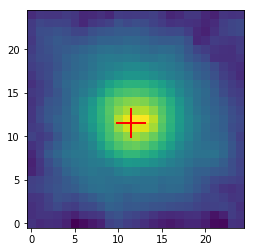

/Users/Dartoon/.local/lib/python2.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


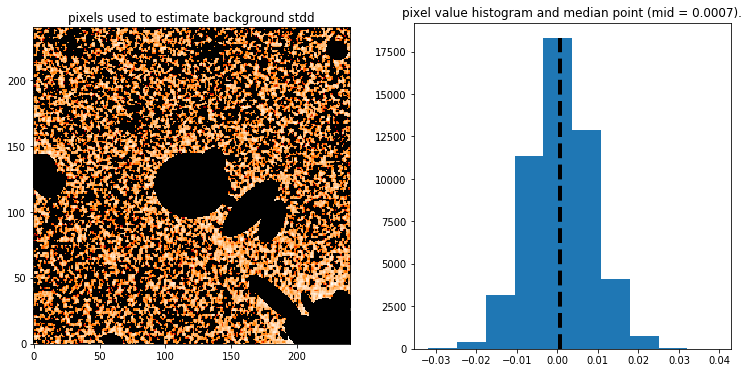

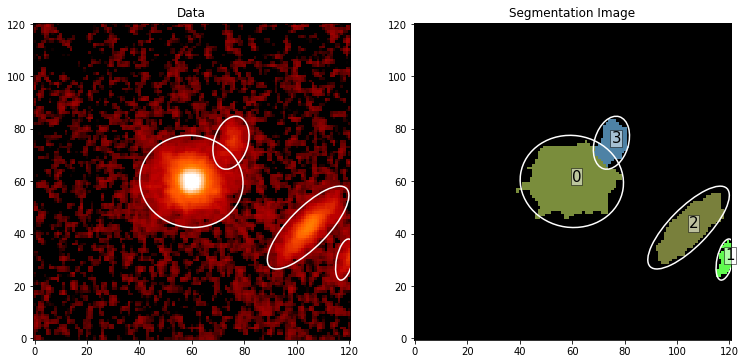

 id xcentroid ycentroid source_sum   orientation    area
       pix       pix                     rad        pix2
--- --------- --------- ---------- --------------- -----
  2    118.37     30.13   2.709306    1.3560558911  54.0
  1    104.42     42.34  29.399893  0.795399011294 338.0
  0     59.87     59.94  217.48721 -0.144017596542 756.0
  3     74.98     74.70   7.206834   1.27683063271 147.0
Input directly the a obj idx to mask, use space between each id:
1


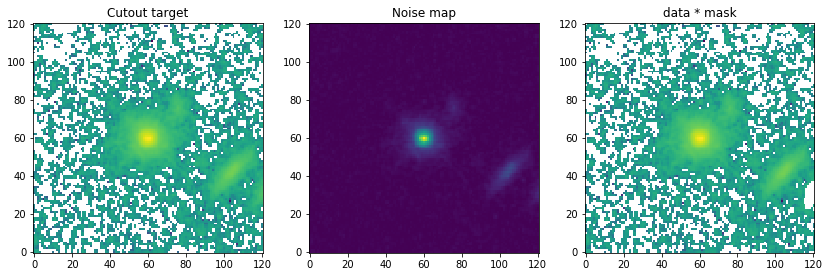

In [3]:
from decomprofile.data_process import DataProcess

#keywords see the notes above.
data_process = DataProcess(fov_image = fov_image, target_pos = [1135, 648], pos_type = 'pixel', header = header,
                          rm_bkglight = False, exptime = exp_map, if_plot=False, zp = 27.0)  #zp use 27.0 for convinence.

data_process.generate_target_materials(radius=60, create_mask = True, nsigma=2.8,
                                      exp_sz= 1.2, npixels = 15, if_plot=True)

/Users/Dartoon/.local/lib/python2.7/site-packages/matplotlib/colors.py:1034: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


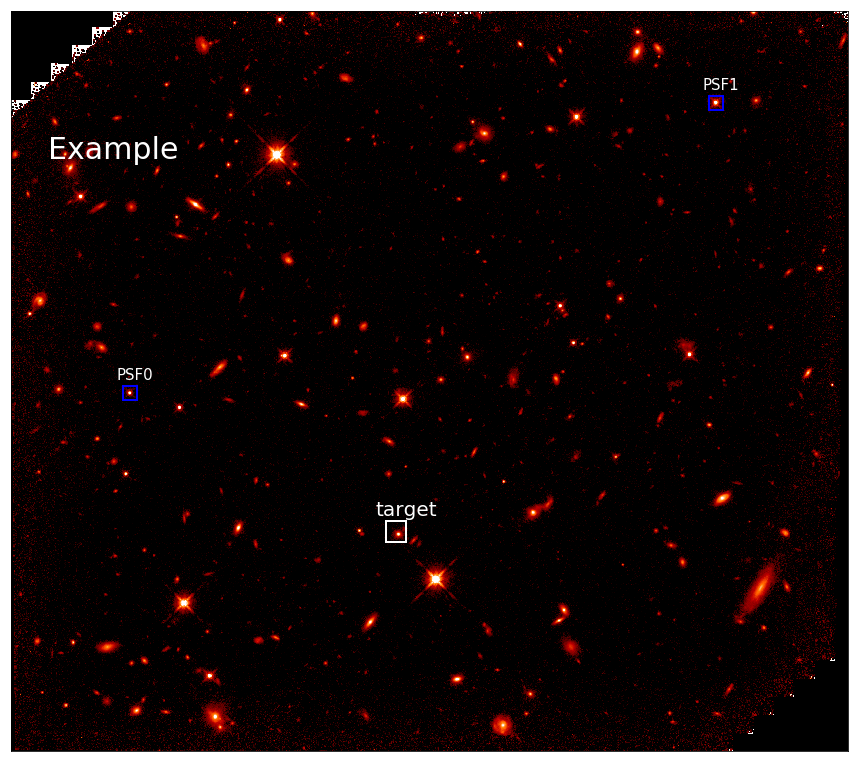

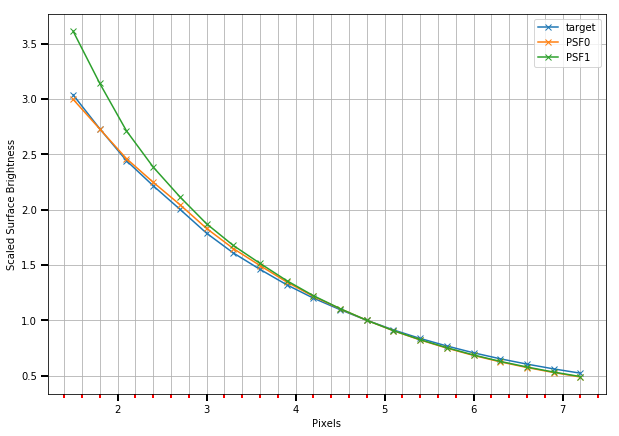

The data_process is ready to go to pass to FittingSpecify!


In [4]:
#find_PSF(): find all the available PSF in the field
#     radius: The radius to cutout the PSF
#     PSF_pos_list: input if PSF positions have selected, input. (combining with pos_type = 'pixel' (default) or 'wcs')
#     if input user_option = False: the one with smallest FWHM would be selected,
#     if input user_option = True: the user can make selection    
data_process.find_PSF(radius = 30, PSF_pos_list = [[ 350., 1055.], [2078., 1910.]])
# data_process.find_PSF(radius = 30, user_option = False) #Try this line out! 
# data_process.find_PSF(radius = 30, user_option = True)  #Try this line out! 

#Plot the FOV image and label the position of the target and the PSF
data_process.plot_overview(label = 'Example', target_label = None)

# Compare the 1D profile of all the components.
data_process.profiles_compare(norm_pix = 5, if_annuli=False, y_log = False,
                  prf_name_list = (['target'] + ['PSF{0}'.format(i) for i in range(len(data_process.PSF_list))]) )

#Select which PSF id you want to use to make the fitting.
data_process.psf_id_for_fitting = 1

#Check if all the materials is given, if so to pass to the next step.
data_process.checkout()

## The following box would quickly prepare the models, parameters and fitting details.

### prepare_fitting_seq includes the following keywords:
    
- point_source_num: number of point source want to used to make the fiting. 
    - point_source_num = 0: galaxy 1: QSO 2: dual AGN
- fix_n_list
    - if one wants to fix any Sersic index value for the component, [[0,4]] means fix Sersic_n of source_id = 0 to 4.
- fix_center_list:
    - if one wants to fix the QSO center to the galaxy center, [0, 1] means fix galaxy_id = 0 center to the QSO_id = 1.
- extend_source_model: manually input the models for the Sersics, i.e., ['SERSIC_ELLIPSE'] * n, n = number of Sersics.
- source_params, ps_params: manually input the galaxy paramters and PS parameters.
    
    

The settings for the fitting is done. Ready to pass to FittingProcess. 
  However, please make updates manullay if needed.


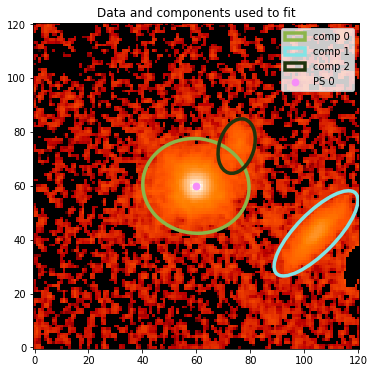

In [5]:
#Produce the class and params to make the QSO decomposition.
from decomprofile.fitting_specify import FittingSpeficy

#Pass the data_process to FittingSpeficy
fit_sepc = FittingSpeficy(data_process)

#Prepare the fitting sequence, keywords see notes above.
fit_sepc.prepare_fitting_seq(point_source_num = 1, fix_n_list= [[0,4]], fix_center_list = [[0,0]], 
                            extend_source_model=None, source_params = None, ps_params = None)

#Plot the initial settings for fittings. 
fit_sepc.plot_fitting_sets()

#Build up and to pass to the next step.
fit_sepc.build_fitting_seq()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
max iteration reached! stoping
(-1.8902515869747119, 'reduced X^2 of best position')
(-13754.415672621491, 'logL')
(14553.0, 'effective number of data points')
([], 'lens result')
([{'R_sersic': 0.1403587458532961, 'n_sersic': 4, 'center_x': 0.007930081327587105, 'center_y': -0.0079383502536578, 'amp': 1, 'e1': 0.0718302799018296, 'e2': 0.03876989881464997}, {'R_sersic': 0.5929401401004257, 'n_sersic': 1.3921655108022828, 'center_x': -2.851794749701726, 'center_y': -1.1090427603188104, 'amp': 1, 'e1': -0.04766553191466615, 'e2': -0.49986023603957863}, {'R_sersic': 0.4157722405693478, 'n_sersic': 2.170660860308336, 'center_x': -1.0126279347947387, 'center_y': 1.033812664236038, 'amp': 1, 'e1': -0.055287929445831066, 'e2': 0.09331010489637574}], 'source result')
([], 'lens light result')
([{'point_amp': [1], 'ra_image': array([0.00793008]), 'dec_image': array([-0.00793835])}], 'point source result')
({}, 'special pa

/Users/Dartoon/.local/lib/python2.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Computing the MCMC...
('Number of walkers = ', 170)
('Burn-in iterations: ', 100)
('Sampling iterations:', 30)
(503.4252419471741, 'time taken for MCMC sampling')
(872.926, 'total time taken for the overall fitting (s)')
============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ 
Start transfering the Params to fluxs...
(5100, 'MCMC samplers in total, finished translate:', 0)
(5100, 'MCMC samplers in total, finished translate:', 1000)
(5100, 'MCMC samplers in total, finished translate:', 2000)
(5100, 'MCMC samplers in total, finished translate:', 3000)
(5100, 'MCMC samplers in total, finished translate:', 4000)
(5100, 'MCMC samplers in total, finished translate:', 5000)


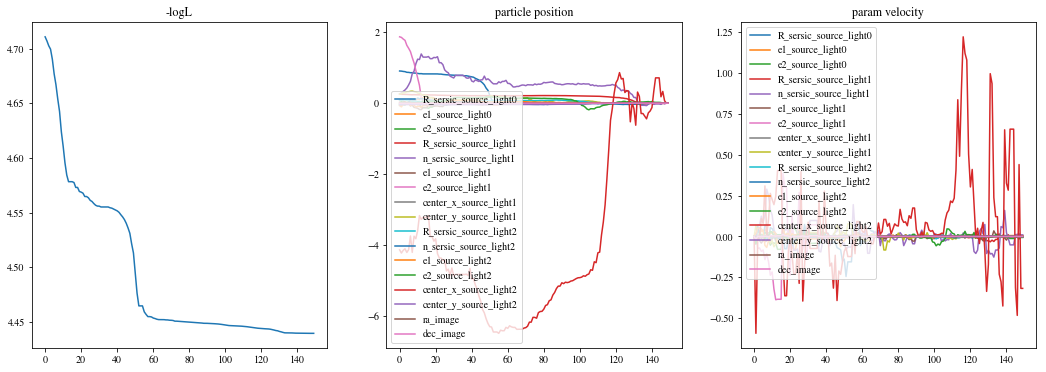

<Figure size 432x288 with 0 Axes>

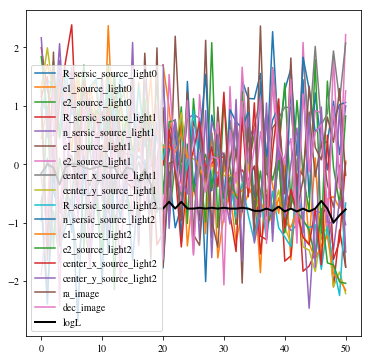

(-1.8848725094380712, 'reduced X^2 of all evaluated imaging data combined.')
('reduced chi^2 of data ', 0, '= ', 1.8848725094380712)


/Users/Dartoon/.local/lib/python2.7/site-packages/lenstronomy/Plots/model_band_plot.py:35: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/Users/Dartoon/.local/lib/python2.7/site-packages/lenstronomy/Plots/model_band_plot.py:35: RuntimeWarning: invalid value encountered in log10
  log_model = np.log10(model)
/Users/Dartoon/.local/lib/python2.7/site-packages/lenstronomy/Plots/model_band_plot.py:82: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/Dartoon/.local/lib/python2.7/site-packages/lenstronomy/Plots/model_band_plot.py:118: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,
/Users/Dartoon/.local/lib/python2.7/site-packages/lenstronomy/Plots/model_band_plot.py:118: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,
/Users/D

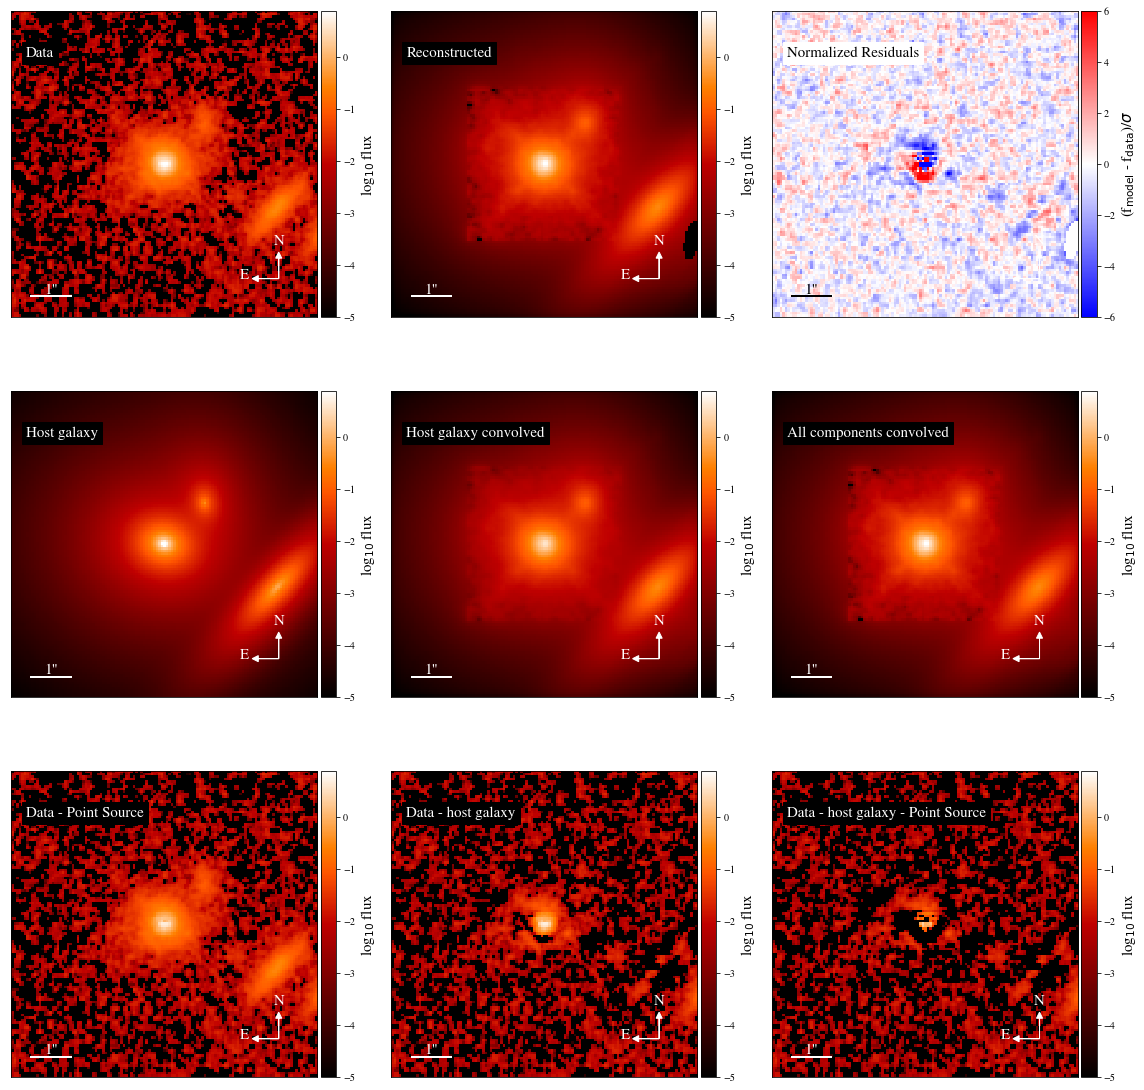

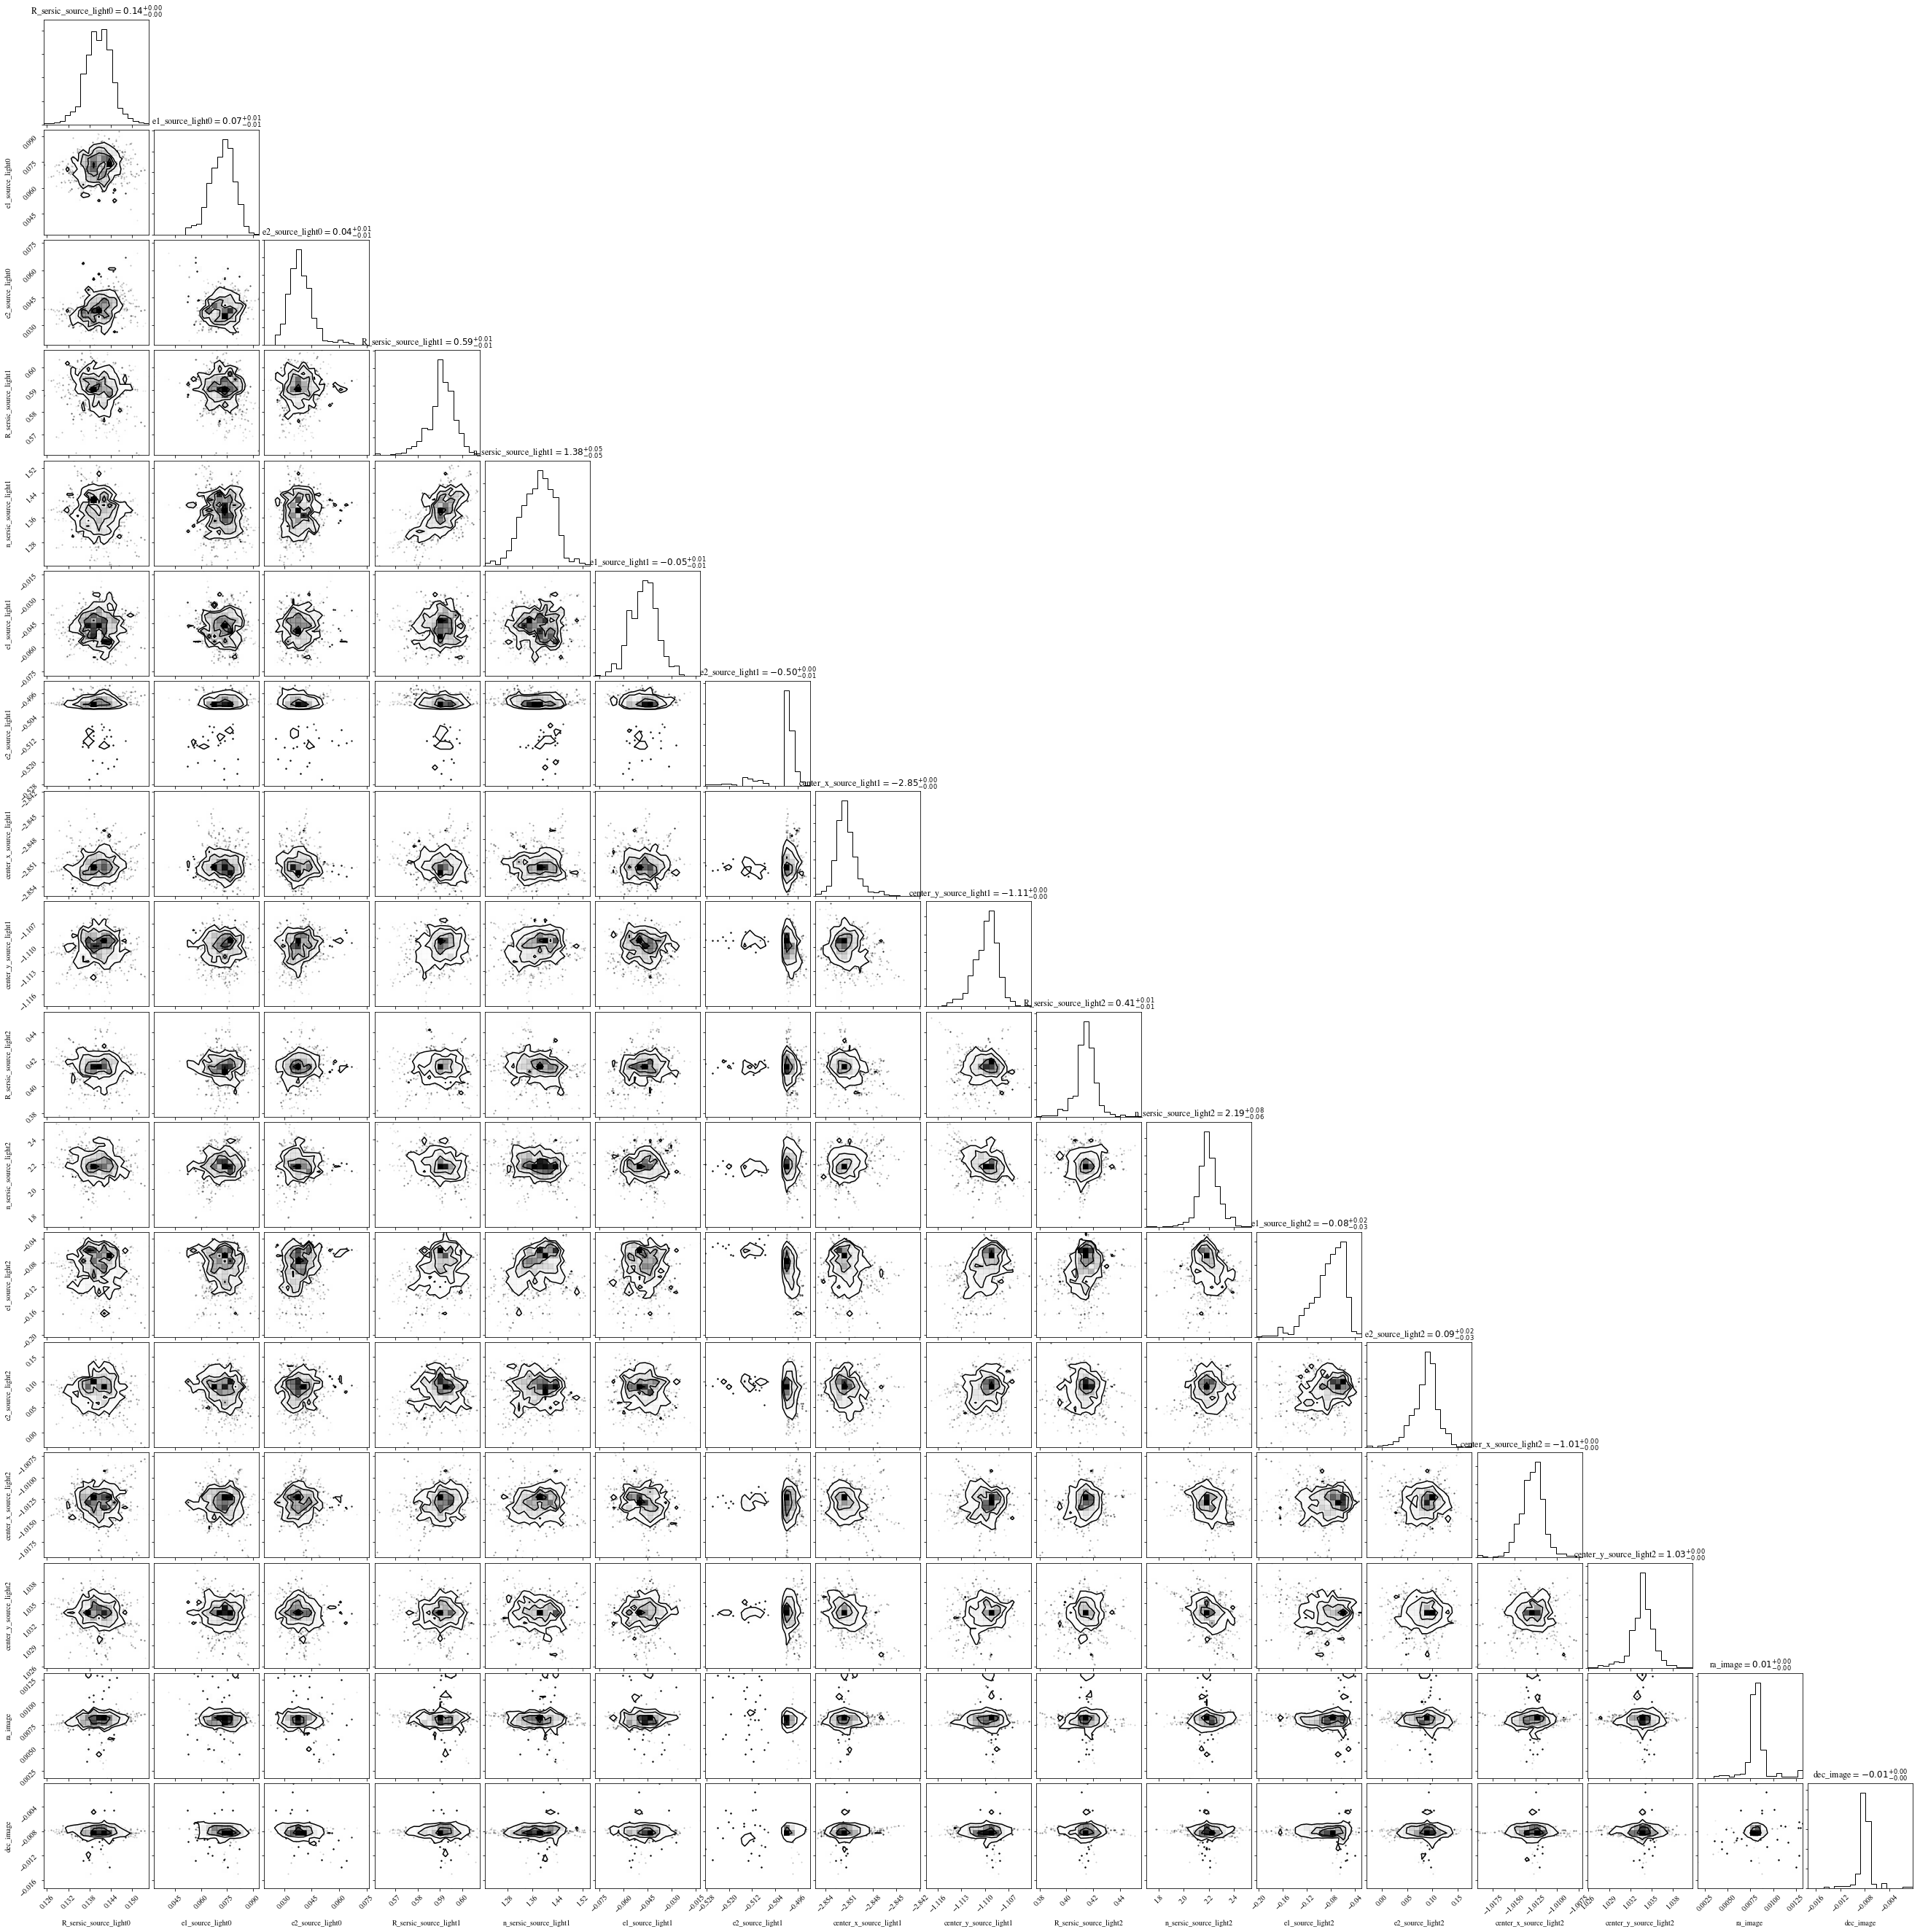

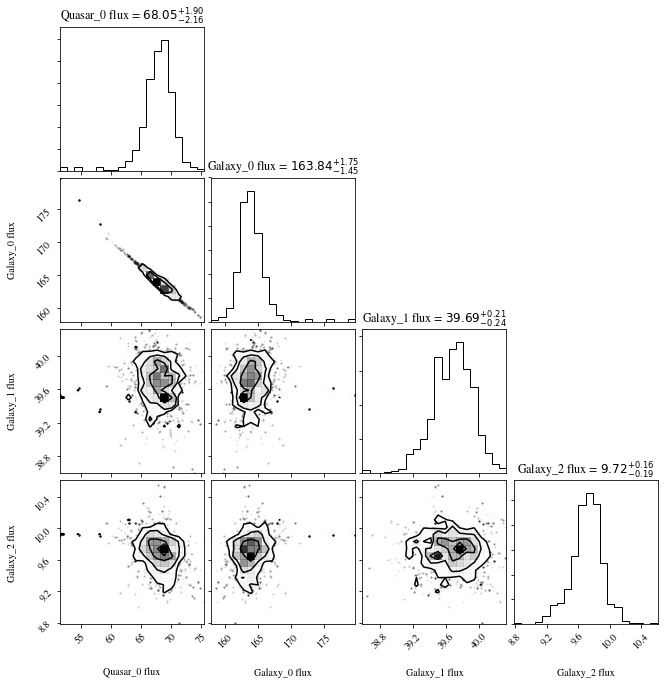

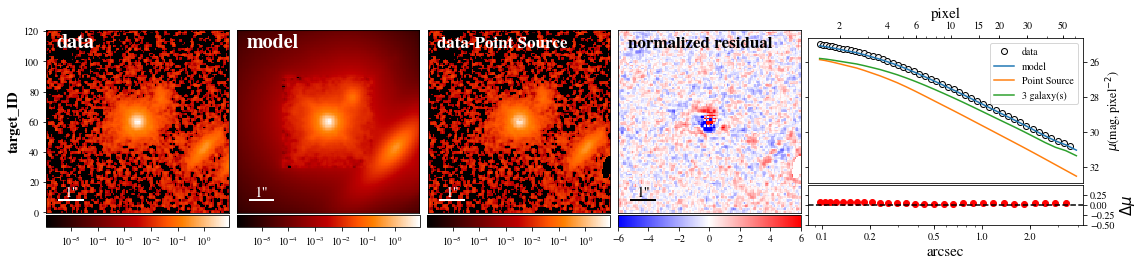

In [6]:
#Setting the fitting method and run.
from decomprofile.fitting_process import FittingProcess

#Pass fit_sepc to FittingProcess,
# savename: The name of the saved files.    
fit_run = FittingProcess(fit_sepc, savename = 'HST_result')

#Setting the fitting approach and Run: 
#     algorithm_list: The fitting approaches that would be used: e.g. ['PSO', 'PSO', 'MCMC']
#     setting_list: The detailed setting for the fitting: e.g. [[0.8, 50, 50], [0.8, 50, 50], [50, 100, 10, 0.1]]
#     -for PSO:
#         [0.8, 50, 50] would input: {'sigma_scale': 0.8, 'n_particles': 50, 'n_iterations': 50}
#     -for MCMC:
#         [50, 100, 10, 0.1] would input: {'n_burn': 50, 'n_run': 100, 'walkerRatio': 10, 'sigma_scale': .1}
#     if setting_list = [None, None, None], default values would be given 
fit_run.run(algorithm_list = ['PSO', 'MCMC'], setting_list = [None, None])

# Plot all the fitting results, including:
#         run_diag() : The convergence of the chains.
#         model_plot(): The model plot (by lenstronomy)
#         plot_params_corner(): The mcmc corner for all the chains (MCMC should be peformed) 
#         plot_flux_corner(): The flux corner for all the component (MCMC should be peformed)
#         plot_final_qso_fit() or plot_final_galaxy_fit(): Plot the overall plot (data, model, data-ps, resudal, 1D profile)
fit_run.plot_all()

#Calculate the magnitude for each component, and translate e1, e1 to q, theta.
fit_run.translate_result()

#Save the fitting class as pickle format:
#     Note, if you use python3 (or 2), load with python3 (or 2)
fit_run.dump_result()

In [8]:
#Load the saved fitting class, the fitting_run_result would be the loaded as fit_run() in previous fittings.
import pickle
picklename = 'HST_result.pkl'
fitting_run_result = pickle.load(open(picklename,'rb'))
#fitting_run_result.plot_final_qso_fit()
fitting_run_result.final_result_galaxy

[{'R_sersic': 0.146965418780821,
  'amp': 397.3255194364184,
  'center_x': 0.008647199950265975,
  'center_y': -0.007828238648975923,
  'e1': 0.07431144725084898,
  'e2': 0.03874262218367836,
  'flux_sersic_model': 194.5040021578917,
  'flux_within_frame': 161.10185371675226,
  'magnitude': 21.482248655868084,
  'n_sersic': 4,
  'phi_G': 0.24029252828224348,
  'q': 0.84535138478905},
 {'R_sersic': 0.5814825697307027,
  'amp': 26.67737344602525,
  'center_x': -2.8495765368295918,
  'center_y': -1.1116575550357066,
  'e1': -0.04538256053360795,
  'e2': -0.49772199972027753,
  'flux_sersic_model': 123.81088834919531,
  'flux_within_frame': 39.46185963254708,
  'magnitude': 23.009556131394085,
  'n_sersic': 1.3699272482629676,
  'phi_G': -0.830862715579077,
  'q': 0.333522942232781},
 {'R_sersic': 0.4096264376157158,
  'amp': 4.553701086905454,
  'center_x': -1.0116393440314706,
  'center_y': 1.0319296296989873,
  'e1': -0.15469320753669846,
  'e2': 0.02535709512883883,
  'flux_sersic_mode